In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sklearn

# sklearn
from sklearn import model_selection # split함수이용
from sklearn import ensemble # RF 
from sklearn import metrics 

# embedding 
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

In [2]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부     
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G

def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")   
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")  
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")

    return G
    
    
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0]
    df_minority = df[df.is_fraud==1]
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled]).reset_index(drop=True)
    df_downsampled = df_downsampled.reindex(np.random.permutation(range(df_downsampled.shape[0]))).reset_index(drop=True)
    return df_downsampled

def embedding(Graph):
    # Graph -> X (feature)
    _edgs = list(Graph.edges)
    subGraph = Graph.edge_subgraph([_edgs[x] for x in range(len(Graph.edges))]).copy()
    subGraph.add_nodes_from(list(set(Graph.nodes) - set(subGraph.nodes)))    
    embedded = AverageEmbedder(Node2Vec(subGraph, weight_key='weight').fit(window=10).wv)
    X = [embedded[str(_edgs[x][0]), str(_edgs[x][1])] for x in range(len(Graph.edges))]
    # Graph -> y (label)
    y = np.array(list(nx.get_edge_attributes(Graph, "label").values()))
    return X,y 

def anal(df):
    Graph = build_graph_bipartite(df)
    X,XX,y,yy = embedding(Graph)
    lrnr = RandomForestClassifier(n_estimators=100, random_state=42) 
    lrnr.fit(X,y)
    yyhat = lrnr.predict(XX)
    df = pd.DataFrame({
        'acc':[sklearn.metrics.accuracy_score(yy,yyhat)], 
        'pre':[sklearn.metrics.precision_score(yy,yyhat)], 
        'rec':[sklearn.metrics.recall_score(yy,yyhat)],
        'f1':[sklearn.metrics.f1_score(yy,yyhat)]}
    )    
    return df

def our_sampling1(df):
    cus_list = set(df.query('is_fraud==1').cc_num.tolist())
    return df.query("cc_num in @ cus_list")

`-` 원본데이터

In [15]:
fraudTrain = pd.read_csv("~/Desktop/fraudTrain.csv").iloc[:,1:]
fraudTrain.shape

(1048575, 22)

In [16]:
fraudTrain.is_fraud.mean().round(5)

0.00573

- 총 1048575의 데이터 중 사기거래는 0.00573

`-` 정상거래의 20퍼 랜덤샘플링

In [17]:
_df1 = fraudTrain[fraudTrain["is_fraud"] == 0].sample(frac=0.20, random_state=42)
_df2 = fraudTrain[fraudTrain["is_fraud"] == 1]
df02 = pd.concat([_df1,_df2])

In [20]:
df02 = pd.concat([_df1,_df2]).reset_index(drop=True)
df02.shape

(214520, 22)

In [21]:
df02.is_fraud.mean().round(5)

0.028

- 총 214,502의 데이터 중 사기거래는 0.028에 해당

`-` downsample

In [22]:
df50 = down_sample_textbook(df02)
df50.shape

(12012, 22)

In [23]:
df50.is_fraud.mean().round(5)

0.5

- 기존 파일에서 사기거래=1인 데이터의 숫자에 맞춰 downsampling함. 

- 12,012의 데이터중 0.5가 사기거래 비율

In [24]:
df02_tr,df02_test = sklearn.model_selection.train_test_split(df02)
df50_tr,df50_test = sklearn.model_selection.train_test_split(df50)

In [27]:
print(df02_tr.shape)
print(df02_test.shape)
print(df50_tr.shape)
print(df50_test.shape)

(160890, 22)
(53630, 22)
(9009, 22)
(3003, 22)


0.75/0.25로 나눴다.

# 분석

In [41]:
X=np.array(df50_tr.amt).reshape(-1,1)
XX = np.array(df50_test.amt).reshape(-1,1)
y = np.array(df50_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

In [45]:
lrnr = sklearn.linear_model.LogisticRegression()

In [46]:
lrnr.fit(X,y)

LogisticRegression()

In [47]:
yyhat = lrnr.predict(XX) 

In [49]:
yyhat

array([1, 1, 1, ..., 0, 1, 0])

In [51]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

In [53]:
{m.__name__:m(yy,yyhat).round(6) for m in metrics}

{'accuracy_score': 0.867799,
 'precision_score': 0.952188,
 'recall_score': 0.776603,
 'f1_score': 0.855479}

In [54]:
Gtr = build_graph_tripartite(df50_tr)
Gtest = build_graph_tripartite(df50_test)

In [55]:
    df=df50.copy();graph_type=nx.Graph()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    

In [56]:
_G = nx.from_edgelist([[0,1],[0,2]])

In [58]:
len([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] + [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()])

24024

In [59]:
len(df50)

12012

In [64]:
df[(df.is_fraud==1)&(df.cc_num==3.598900e+15)]

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,in_node,out_node
686,2019-11-25 22:26,3.598900e+15,fraud_Kilback LLC,grocery_pos,320.26,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,de391d925e1aa1f86cc77cf0e8f0e21b,1353882366,41.042223,-82.308471,1,12668,12614
925,2019-11-25 23:48,3.598900e+15,fraud_Kassulke PLC,shopping_net,948.05,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,61df1730a076116730249af6e92c3ffb,1353887312,41.157798,-82.108063,1,12668,12241
1352,2019-11-25 3:38,3.598900e+15,fraud_Kuvalis Ltd,gas_transport,12.63,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,4681eb64a8a2f95281afdcb7ddb43c4f,1353814696,41.082232,-82.864767,1,12668,12783
3113,2019-11-24 3:51,3.598900e+15,fraud_Koepp-Parker,grocery_pos,308.82,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,726d491f80a2c4db905fefe75290cdc8,1353729072,40.523117,-82.073365,1,12668,13061
3219,2019-11-25 22:41,3.598900e+15,fraud_Bechtelar-Rippin,food_dining,127.81,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,94f80338f56e539310f84c10c9c11fa8,1353883286,41.226756,-83.475536,1,12668,12392
7647,2019-11-25 22:44,3.598900e+15,"fraud_Kihn, Abernathy and Douglas",shopping_net,968.41,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,2a1a6053c916e39ed512338017bed155,1353883476,41.394215,-82.910453,1,12668,13072
9546,2019-11-25 22:21,3.598900e+15,"fraud_Heathcote, Yost and Kertzmann",shopping_net,1074.33,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,11ee1c8458d0d448d55de05c4c8a0fe9,1353882077,41.869650,-82.354703,1,12668,13303
11881,2019-11-24 23:35,3.598900e+15,fraud_Schaefer Ltd,kids_pets,16.53,Kenneth,Richards,M,994 Livingston Extensions Suite 918,Norwalk,...,23805,Copy,1970-02-22,2a8b2e1497ff931108e47f5131ffbf5d,1353800139,41.431914,-82.661167,1,12668,12681


In [65]:
import matplotlib.pyplot as plt

In [66]:
len(df02.loc[(df02.cc_num==3.598900e+15),'amt'])

95

In [67]:
len(df50.loc[(df02.cc_num==3.598900e+15),'amt'])

3

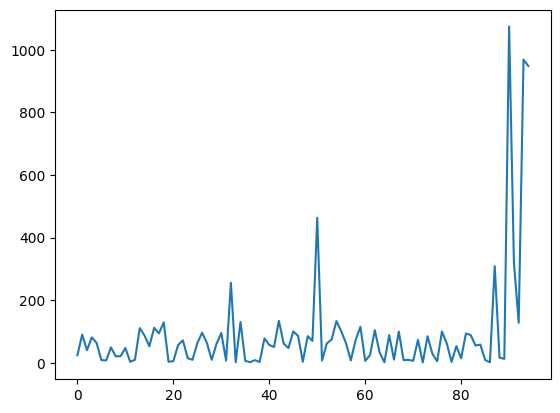

In [68]:
plt.plot(list(range(95)),df02.loc[(df02.cc_num==3.598900e+15),'amt'])

In [72]:
_y= np.array(df02.loc[(df02.cc_num==3.598900e+15),'amt'])

In [74]:
s=_y*0

In [77]:
for i in range(1,95):
    s[i] = s[i-1] + _y[i]-np.mean(_y)

In [80]:
_z=(_y-np.median(_y))/np.std(_y)

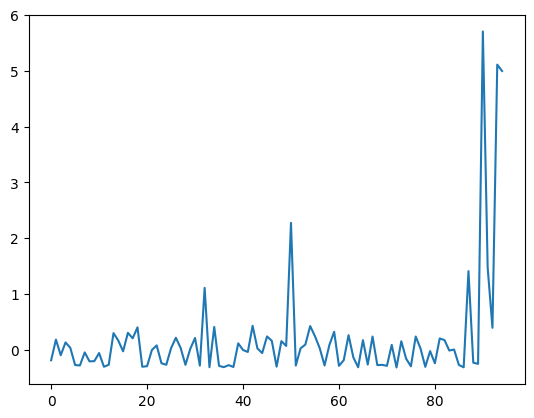

In [81]:
plt.plot(_z)

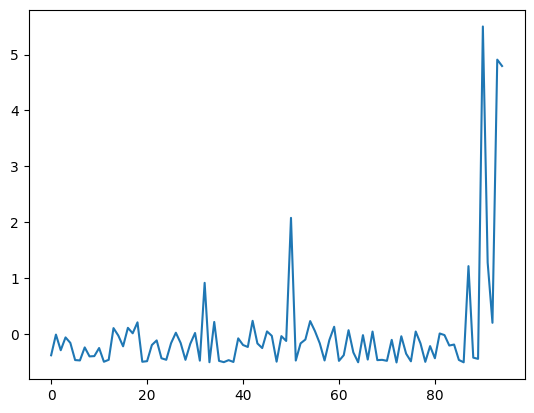

In [82]:
_t=(_y-np.mean(_y))/np.std(_y)
plt.plot(_t)

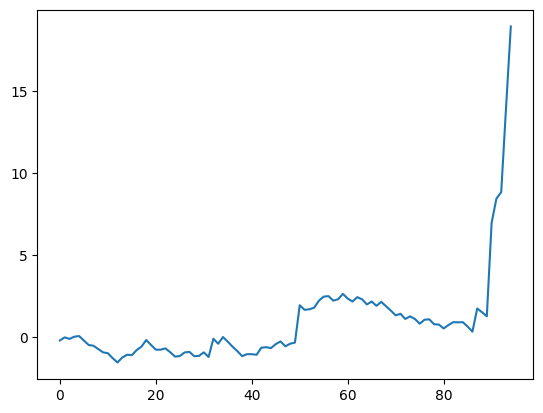

In [85]:
plt.plot(_z.cumsum())

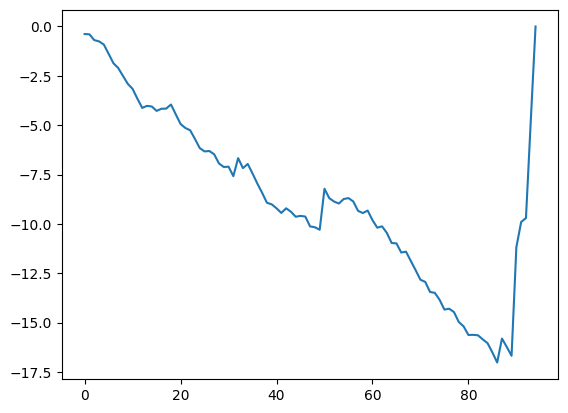

In [86]:
plt.plot(_t.cumsum())

평균내면 -값 나와서.. 그래프가 이렇게

In [90]:
_X,_y = embedding(Gtr)
_XX,_yy = embedding(Gtest)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


In [94]:
print(len(_X),len(_y), len(_XX),len(_yy))

6006 6006 6006 6006


In [99]:
print(df50_tr.shape, len(_X), df50_test.shape, len(_XX))

(9009, 22) 6006 (3003, 22) 6006


In [100]:
X = np.array(df50_tr.amt).reshape(-1,1)
XX = np.array(df50_test.amt).reshape(-1,1)
y = np.array(df50_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

In [103]:
np.stack(_X).shape

(6006, 128)

In [104]:
X.shape, np.stack(_X).shape

((9009, 1), (6006, 128))

_X는 그래프 임베딩 한건데, 뭘까

In [105]:
len(_yy),len(_y)

(6006, 6006)

In [106]:
lrnr = sklearn.linear_model.LogisticRegression()

In [107]:
lrnr.fit(_X,_y)

LogisticRegression()

In [108]:
_yyhat = lrnr.predict(_XX) 

In [114]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]


In [115]:
{m.__name__:m(_yy,_yyhat).round(6) for m in metrics}

{'accuracy_score': 0.511655,
 'precision_score': 0.577371,
 'recall_score': 0.114673,
 'f1_score': 0.191343}

교수님것에서는 len(_X)= 2970 나왔는데

In [116]:
G = build_graph_bipartite(df50)

In [117]:
df50.shape

(12012, 22)

In [120]:
X,XX,y,yy = embedding(G)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


ValueError: not enough values to unpack (expected 4, got 2)

In [122]:
np.stack(X).shape, np.stack(XX).shape

((9009, 1), (3003, 1))

In [123]:
np.array(y).shape,np.array(yy).shape

((9009,), (3003,))

In [125]:
from sklearn.ensemble import RandomForestClassifier


In [126]:
lrnr = RandomForestClassifier(n_estimators=100, random_state=42) 
lrnr.fit(np.stack(X),np.array(y))

RandomForestClassifier(random_state=42)

In [127]:
np.mean(lrnr.predict(XX) == yy)

0.8608058608058609

In [129]:
anal(down_sample_textbook(df))

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
anal(down_sample_textbook(our_sampling1(df)))